In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.interpolate import interp1d

TODO:
- [ ] Add more visualizations (Sophie)
- [ ] Missing values          (Amir)
  - [x] backfill for 1 day
  - [x] In case of long missing values, we still have to figure out what to do 
    - Most missing values after the day baqckfilling ended up being the most obscure appCat's so I simply set them to 0
  - [-] Aggregating over Days/Hours

- [ ] Outlier detection        (Sophie)
  - [ ] Grubs/ VIF/ Cook's distance (Not all of them)

- [ ] Feature engineering     (Nabila)
  - [ ] PCA                   
    - [ ] Whitening
    


In [2]:
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 18,
    "axes.titlesize": 18,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "figure.figsize": (8, 6),
    "figure.dpi": 100,
    "savefig.dpi": 200,
    "savefig.format": "png",
    "savefig.transparent": True,
    "axes.grid": True,
    "grid.linewidth": 0.5,
    "grid.linestyle": "--",
    "grid.color": "0.8",
    "image.cmap": "Blues",
    "lines.linewidth": 1.5,
    "lines.markersize": 6,
    "text.usetex": True, "mathtext.fontset": "cm",
    "pgf.preamble": r"\usepackage[utf8]{inputenc}\usepackage[T1]{fontenc}\usepackage{cmbright}"
})


In [3]:
data = pd.read_csv("dataset_mood_smartphone.csv", index_col=0)
data['time'] = pd.to_datetime(data['time'])
data['time'] = data['time'].dt.round('H')
print(data.tail())

              id                time        variable   value
2770399  AS14.30 2014-04-11 08:00:00  appCat.weather   8.032
2772465  AS14.30 2014-04-19 11:00:00  appCat.weather   3.008
2774026  AS14.30 2014-04-26 10:00:00  appCat.weather   7.026
2774133  AS14.30 2014-04-27 01:00:00  appCat.weather  23.033
2784435  AS14.32 2014-04-07 18:00:00  appCat.weather  22.431


/var/folders/k8/f4s3z1312zg_dxlmjk7hjk1c0000gn/T/ipykernel_5310/998225388.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data['time'] = data['time'].dt.round('H')


In [4]:
# Convert time column to datetime format
data['time'] = pd.to_datetime(data['time'])
data['time'] = data['time'].dt.round('H')


# Pivot the data to create separate columns for each variable
data_pivot = data.pivot_table(index=['id', 'time'], columns='variable', values='value')

# Reset the index to flatten the column hierarchy
data_pivot.reset_index(inplace=True)

# Handle missing values
data_pivot.fillna(method='bfill', inplace=True)  # back-fill missing values

/var/folders/k8/f4s3z1312zg_dxlmjk7hjk1c0000gn/T/ipykernel_5310/2682011612.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data['time'] = data['time'].dt.round('H')
/var/folders/k8/f4s3z1312zg_dxlmjk7hjk1c0000gn/T/ipykernel_5310/2682011612.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pivot.fillna(method='bfill', inplace=True)  # back-fill missing values


In [5]:
print(data_pivot.describe().to_markdown())

|       | time                          |     activity |   appCat.builtin |   appCat.communication |   appCat.entertainment |   appCat.finance |   appCat.game |   appCat.office |   appCat.other |   appCat.social |   appCat.travel |   appCat.unknown |   appCat.utilities |   appCat.weather |   call |   circumplex.arousal |   circumplex.valence |        mood |        screen |   sms |
|:------|:------------------------------|-------------:|-----------------:|-----------------------:|-----------------------:|-----------------:|--------------:|----------------:|---------------:|----------------:|----------------:|-----------------:|-------------------:|-----------------:|-------:|---------------------:|---------------------:|------------:|--------------:|------:|
| count | 27028                         | 27026        |      27027       |             27027      |              27026     |       26287      |    23775      |      26974      |     27025      |      27026      |      27022      | 

|       | time                          |     activity |   appCat.builtin |   appCat.communication |   appCat.entertainment |   appCat.finance |   appCat.game |   appCat.office |   appCat.other |   appCat.social |   appCat.travel |   appCat.unknown |   appCat.utilities |   appCat.weather |   call |   circumplex.arousal |   circumplex.valence |        mood |        screen |   sms |
|:------|:------------------------------|-------------:|-----------------:|-----------------------:|-----------------------:|-----------------:|--------------:|----------------:|---------------:|----------------:|----------------:|-----------------:|-------------------:|-----------------:|-------:|---------------------:|---------------------:|------------:|--------------:|------:|
| count | 27028                         | 27026        |      27027       |             27027      |              27026     |       26287      |    23775      |      26974      |     27025      |      27026      |      27022      |       27019      |         27027      |       25009      |  27022 |         27028        |         27028        | 27028       | 27026         | 27005 |
| mean  | 2014-04-14 16:34:06.144738816 |     0.120058 |         42.3545  |                45.6104 |                120.543 |          31.3167 |      356.289  |         45.7802 |        20.9953 |         89.0727 |         50.4012 |          42.3354 |            18.4875 |          29.719  |      1 |            -0.217589 |             0.668732 |     6.94341 |   113.027     |     1 |
| min   | 2014-02-17 07:00:00           |     0        |      -6343.29    |                 0.117  |                  0.005 |           1.003  |        1.003  |          0.044  |         0.014  |          0.552  |          0.08   |           0.111  |             0.976  |           1.007  |      1 |            -2        |            -2        |     1       |     0.0350001 |     1 |
| 25%   | 2014-04-02 06:45:00           |     0        |          4.41667 |                13.12   |                 10.794 |           8.014  |       80.6005 |         10.046  |         8.037  |         17.861  |         22.122  |          11.044  |             4.033  |           5.22   |      1 |            -1        |             0        |     6       |    19.334     |     1 |
| 50%   | 2014-04-15 15:00:00           |     0.025    |          8.02163 |                27.6707 |                 34.246 |          21.601  |      169.699  |         23.264  |        10.257  |         44.566  |         38.4282 |          21.185  |            10.537  |          10.147  |      1 |             0        |             1        |     7       |    44.771     |     1 |
| 75%   | 2014-04-27 22:00:00           |     0.158333 |         16.3092  |                51.6465 |                123.965 |          51.205  |      478.826  |         45.241  |        16.514  |        102.588  |         61.5086 |          30.178  |            20.0615 |          22.431  |      1 |             1        |             1        |     8       |    94.8592    |     1 |
| max   | 2014-06-09 00:00:00           |     1        |      19453       |              3133.48   |               2929.61  |         315.481  |     4115.3    |       4675.7    |      2243.24   |      15001.5    |       3492.32   |        2239.94   |           447.918  |         344.863  |      1 |             2        |             2        |    10       |  9539.82      |     1 |
| std   | nan                           |     0.190739 |        582.008   |                85.285  |                217.58  |          29.7814 |      634.744  |         80.0885 |        56.8702 |        161.532  |         76.5206 |         108.084  |            38.2665 |          70.1424 |      0 |             1.0681   |             0.686026 |     1.0813  |   338.403     |     0 |

In [6]:
# fill in the screen time for the entire day, sum the number of sms and call for the entire day

data_pivot['day'] = data_pivot['time'].dt.floor('D')
data_pivot['screen'] = data_pivot['screen'].groupby([data_pivot['id'], data_pivot['day']]).transform('sum')
data_pivot['sms'] = data_pivot['sms'].groupby([data_pivot['id'], data_pivot['day']]).transform('sum')
data_pivot['call'] = data_pivot['call'].groupby([data_pivot['id'], data_pivot['day']]).transform('sum')

In [7]:
data_pivot.head(10)

variable,id,time,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,...,appCat.unknown,appCat.utilities,appCat.weather,call,circumplex.arousal,circumplex.valence,mood,screen,sms,day
0,AS14.01,2014-02-17 12:00:00,0.071429,2.288,4.19,14.197667,6.065333,116.518,62.281,10.343,...,45.173,10.537,30.386,2.0,-1.0,0.0,6.0,285.7010,2.0,2014-02-17
1,AS14.01,2014-02-17 18:00:00,0.071429,2.288,4.19,14.197667,6.065333,116.518,62.281,10.343,...,45.173,10.537,30.386,2.0,-1.0,0.0,6.0,285.7010,2.0,2014-02-17
2,AS14.01,2014-02-18 09:00:00,0.071429,2.288,4.19,14.197667,6.065333,116.518,62.281,10.343,...,45.173,10.537,30.386,1.0,-1.0,0.0,6.0,142.8505,1.0,2014-02-18
3,AS14.01,2014-02-19 15:00:00,0.071429,2.288,4.19,14.197667,6.065333,116.518,62.281,10.343,...,45.173,10.537,30.386,4.0,-1.0,0.0,6.0,571.4020,4.0,2014-02-19
4,AS14.01,2014-02-19 17:00:00,0.071429,2.288,4.19,14.197667,6.065333,116.518,62.281,10.343,...,45.173,10.537,30.386,4.0,-1.0,0.0,6.0,571.4020,4.0,2014-02-19
5,AS14.01,2014-02-19 18:00:00,0.071429,2.288,4.19,14.197667,6.065333,116.518,62.281,10.343,...,45.173,10.537,30.386,4.0,-1.0,0.0,6.0,571.4020,4.0,2014-02-19
6,AS14.01,2014-02-19 21:00:00,0.071429,2.288,4.19,14.197667,6.065333,116.518,62.281,10.343,...,45.173,10.537,30.386,4.0,-1.0,0.0,6.0,571.4020,4.0,2014-02-19
7,AS14.01,2014-02-20 11:00:00,0.071429,2.288,4.19,14.197667,6.065333,116.518,62.281,10.343,...,45.173,10.537,30.386,2.0,-1.0,0.0,6.0,285.7010,2.0,2014-02-20
8,AS14.01,2014-02-20 14:00:00,0.071429,2.288,4.19,14.197667,6.065333,116.518,62.281,10.343,...,45.173,10.537,30.386,2.0,-1.0,0.0,6.0,285.7010,2.0,2014-02-20
9,AS14.01,2014-02-21 16:00:00,0.071429,2.288,4.19,14.197667,6.065333,116.518,62.281,10.343,...,45.173,10.537,30.386,1.0,-1.0,0.0,6.0,142.8505,1.0,2014-02-21


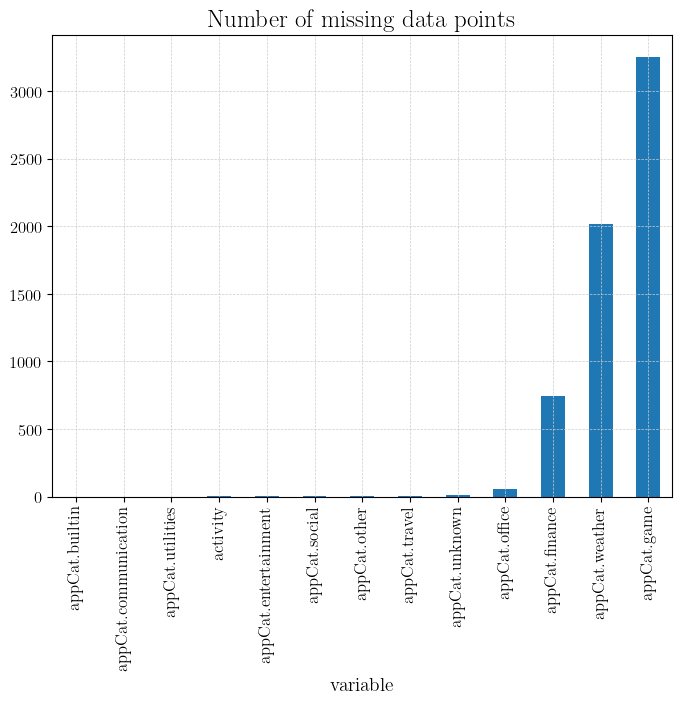

In [8]:
# Visualize the number of missing data points
missing = data_pivot.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot(kind='bar', title='Number of missing data points')
plt.show()

For the values here there a few missing points, we can use a sliding window to fill in the missing values
For the values where there are many value missing, these seem like varaibles where there they have mostly 0 values, so we can fill in the missing values with 0

In [9]:
for column in data_pivot.columns:
    # window sliding fill
    if 0 < data_pivot[column].isnull().sum() < 500:
        data_pivot[column][data_pivot[column].isnull()] = data_pivot[column].rolling(24, min_periods=1).mean()


data_pivot = data_pivot.fillna(0)

/var/folders/k8/f4s3z1312zg_dxlmjk7hjk1c0000gn/T/ipykernel_5310/1895976420.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data_pivot[column][data_pivot[column].isnull()] = data_pivot[column].rolling(24, min_periods=1).mean()
/var/folder

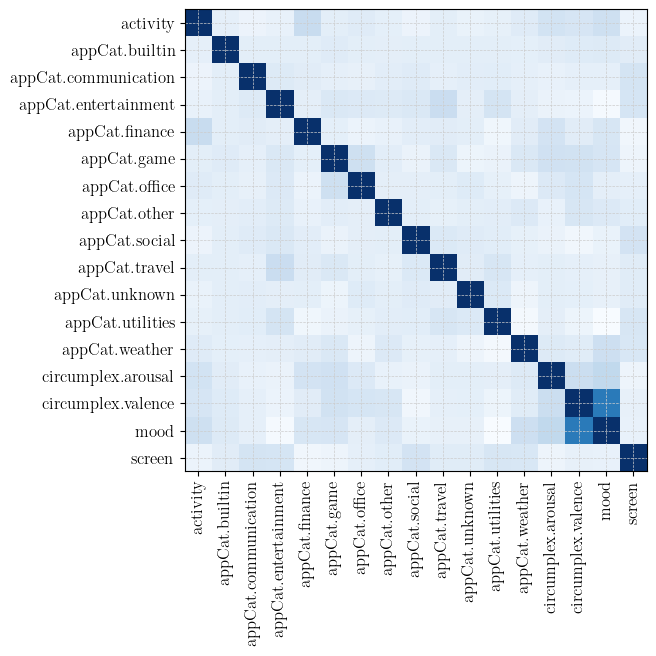

In [10]:
# get correlation matrix ignoring time and id

# numeric only
num_grouped = data_pivot.select_dtypes(include=[np.number])
# Drop call and sms variables
num_grouped = num_grouped.drop(columns=['call', 'sms'])
corr = num_grouped.corr()
plt.imshow(corr, cmap='Blues', interpolation='nearest')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.show()

## More Data Visualizations, i.e. stuff Sophie just added
It seems like something might be strange about the call and SMS data because they produce the exact same graph. 

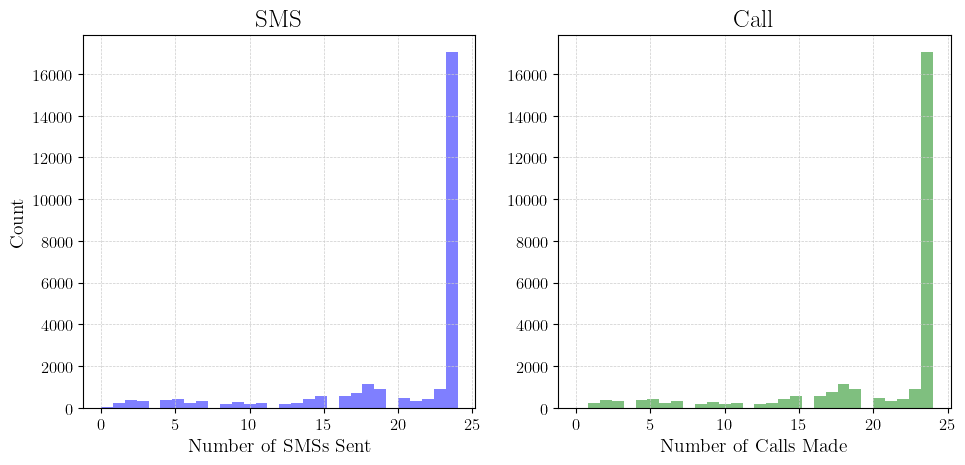

In [11]:
#Histograms for Call and SMS overall

sms_data = data_pivot["sms"]
call_data = data_pivot["call"]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].hist(sms_data, bins=30, color='blue', alpha=0.5)
axes[0].set_xlabel("Number of SMSs Sent")
axes[0].set_ylabel("Count")
axes[0].set_title('SMS')

axes[1].hist(call_data, bins=30, color='green', alpha=0.5)
axes[1].set_xlabel("Number of Calls Made")
axes[1].set_title('Call')

plt.tight_layout()
plt.show()

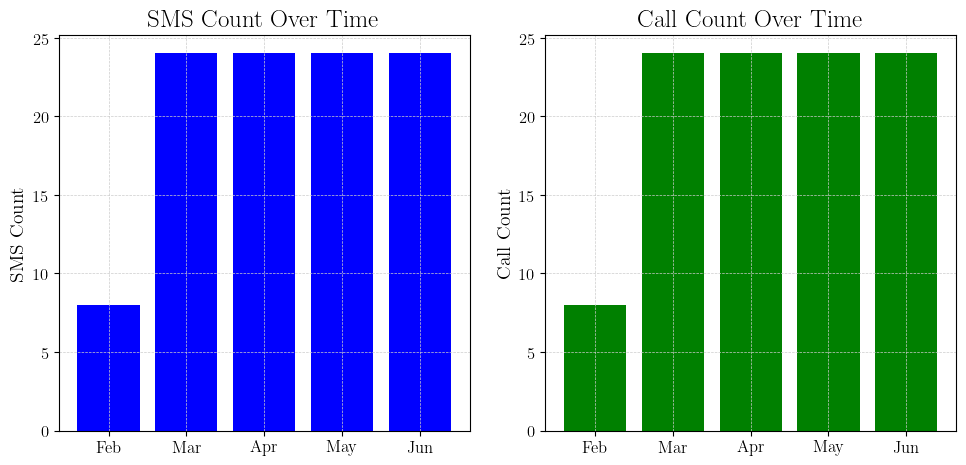

In [12]:
#Bar plots for call and SMS over time

days = data_pivot['day']
sms_counts = data_pivot['sms']
call_counts = data_pivot['call']
time_sorted = sorted(days)
sorted_sms_counts = [sms_counts[index] for index in sorted(range(len(days)), key=lambda x: days[x])]
sorted_call_counts = [call_counts[index] for index in sorted(range(len(days)), key=lambda x: days[x])]
months = [date.strftime('%b') for date in time_sorted]

#SMS Data
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].bar(months, sorted_sms_counts, color='blue', alpha=0.5)
axes[0].set_ylabel('SMS Count')
axes[0].set_title('SMS Count Over Time')

#Call Data
axes[1].bar(months, sorted_call_counts, color='green', alpha=0.5)
axes[1].set_ylabel('Call Count')
axes[1].set_title('Call Count Over Time')


plt.tight_layout()
plt.show()


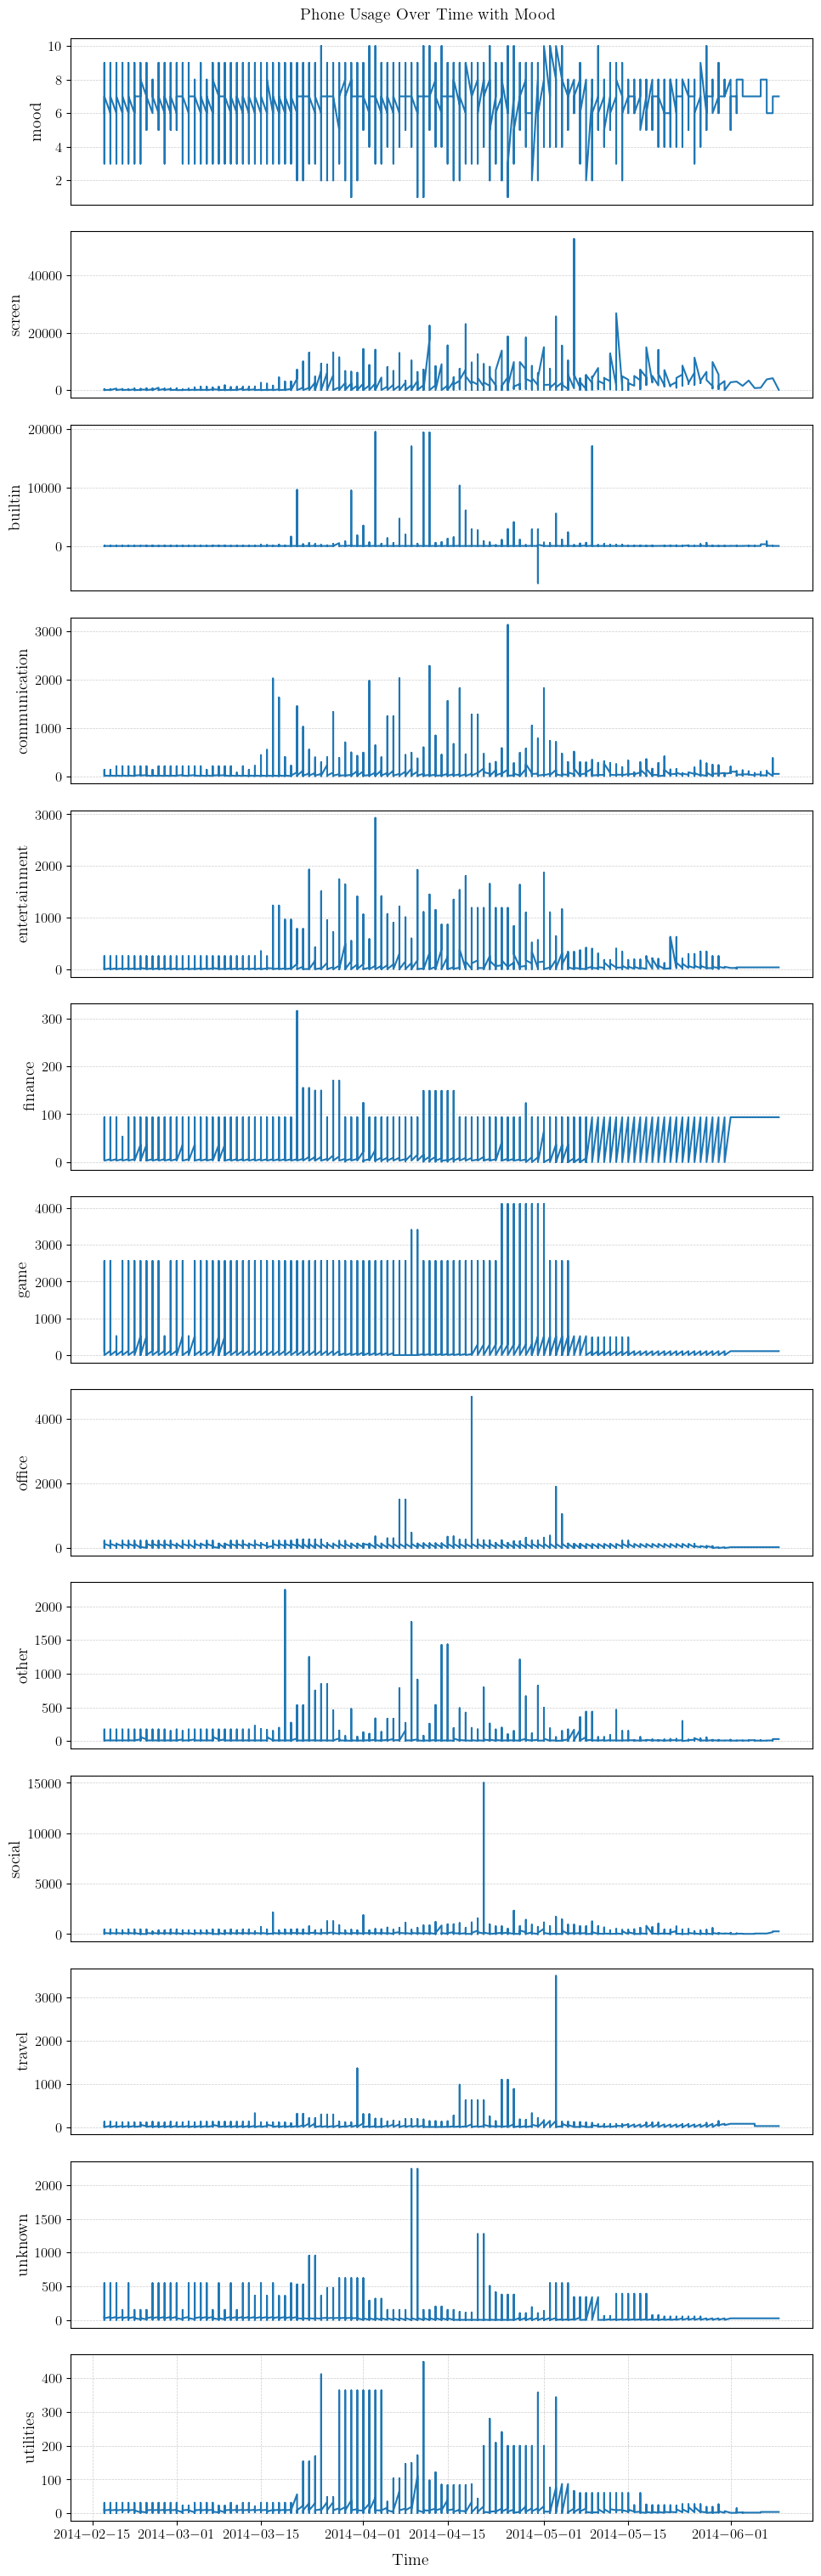

In [26]:
#Trying to make the pretty graph LaTeX style for dear Amir
days = data_pivot['day']
sorted_time_marks = sorted(days)

mood = data_pivot['mood']
screen = data_pivot['screen']
builtin = data_pivot['appCat.builtin']
communication = data_pivot['appCat.communication']
entertainment = data_pivot['appCat.entertainment']
finance = data_pivot['appCat.finance']
game = data_pivot['appCat.game']
office = data_pivot['appCat.office']
other = data_pivot['appCat.other']
social = data_pivot['appCat.social']
travel = data_pivot['appCat.travel']
unknown = data_pivot['appCat.unknown']
utilities = data_pivot['appCat.utilities']

sorted_mood = [mood[index] for index in sorted(range(len(days)), key=lambda x: days[x])]
sorted_screen = [screen[index] for index in sorted(range(len(days)), key=lambda x: days[x])]
sorted_builtin = [builtin[index] for index in sorted(range(len(days)), key=lambda x: days[x])]
sorted_communication = [communication[index] for index in sorted(range(len(days)), key=lambda x: days[x])]
sorted_entertainment = [entertainment[index] for index in sorted(range(len(days)), key=lambda x: days[x])]
sorted_finance = [finance[index] for index in sorted(range(len(days)), key=lambda x: days[x])]
sorted_game = [game[index] for index in sorted(range(len(days)), key=lambda x: days[x])]
sorted_office = [office[index] for index in sorted(range(len(days)), key=lambda x: days[x])]
sorted_other = [other[index] for index in sorted(range(len(days)), key=lambda x: days[x])]
sorted_social = [social[index] for index in sorted(range(len(days)), key=lambda x: days[x])]
sorted_travel = [travel[index] for index in sorted(range(len(days)), key=lambda x: days[x])]
sorted_unknown = [unknown[index] for index in sorted(range(len(days)), key=lambda x: days[x])]
sorted_utilities = [utilities[index] for index in sorted(range(len(days)), key=lambda x: days[x])]

fig, axes = plt.subplots(nrows=13, ncols=1, figsize=(10, 30))

#I can probably do this with a loop, but I might ask Mr. ChatGPT to do that for me later.
axes[0].plot(sorted_time_marks, sorted_mood, label='Screen')
axes[1].plot(sorted_time_marks, sorted_screen, label='Screen')
axes[2].plot(sorted_time_marks, sorted_builtin, label='Built-in')
axes[3].plot(sorted_time_marks, sorted_communication, label='Communication')
axes[4].plot(sorted_time_marks, sorted_entertainment, label='Entertainment')
axes[5].plot(sorted_time_marks, sorted_finance, label='Finance')
axes[6].plot(sorted_time_marks, sorted_game, label='Game')
axes[7].plot(sorted_time_marks, sorted_office, label='Office')
axes[8].plot(sorted_time_marks, sorted_other, label='Other')
axes[9].plot(sorted_time_marks, sorted_social, label='Social')
axes[10].plot(sorted_time_marks, sorted_travel, label='Travel')
axes[11].plot(sorted_time_marks, sorted_unknown, label='Unknown')
axes[12].plot(sorted_time_marks, sorted_utilities, label='Utilities')

y_labels = ['mood','screen','builtin','communication','entertainment','finance','game','office','other','social','travel','unknown','utilities']

#Messing with some of the formatting
for i in range(12):
    axes[i].set_xticklabels([])
    axes[i].set_xticks([])
    axes[i].set_ylabel(y_labels[i])

axes[12].set_ylabel(y_labels[12])
fig.text(0.37, 1, 'Phone Usage Over Time with Mood', va='center', rotation='horizontal', fontsize=14)
fig.text(0.5, 0, 'Time', ha='center', fontsize=14)

plt.tight_layout()
plt.show()

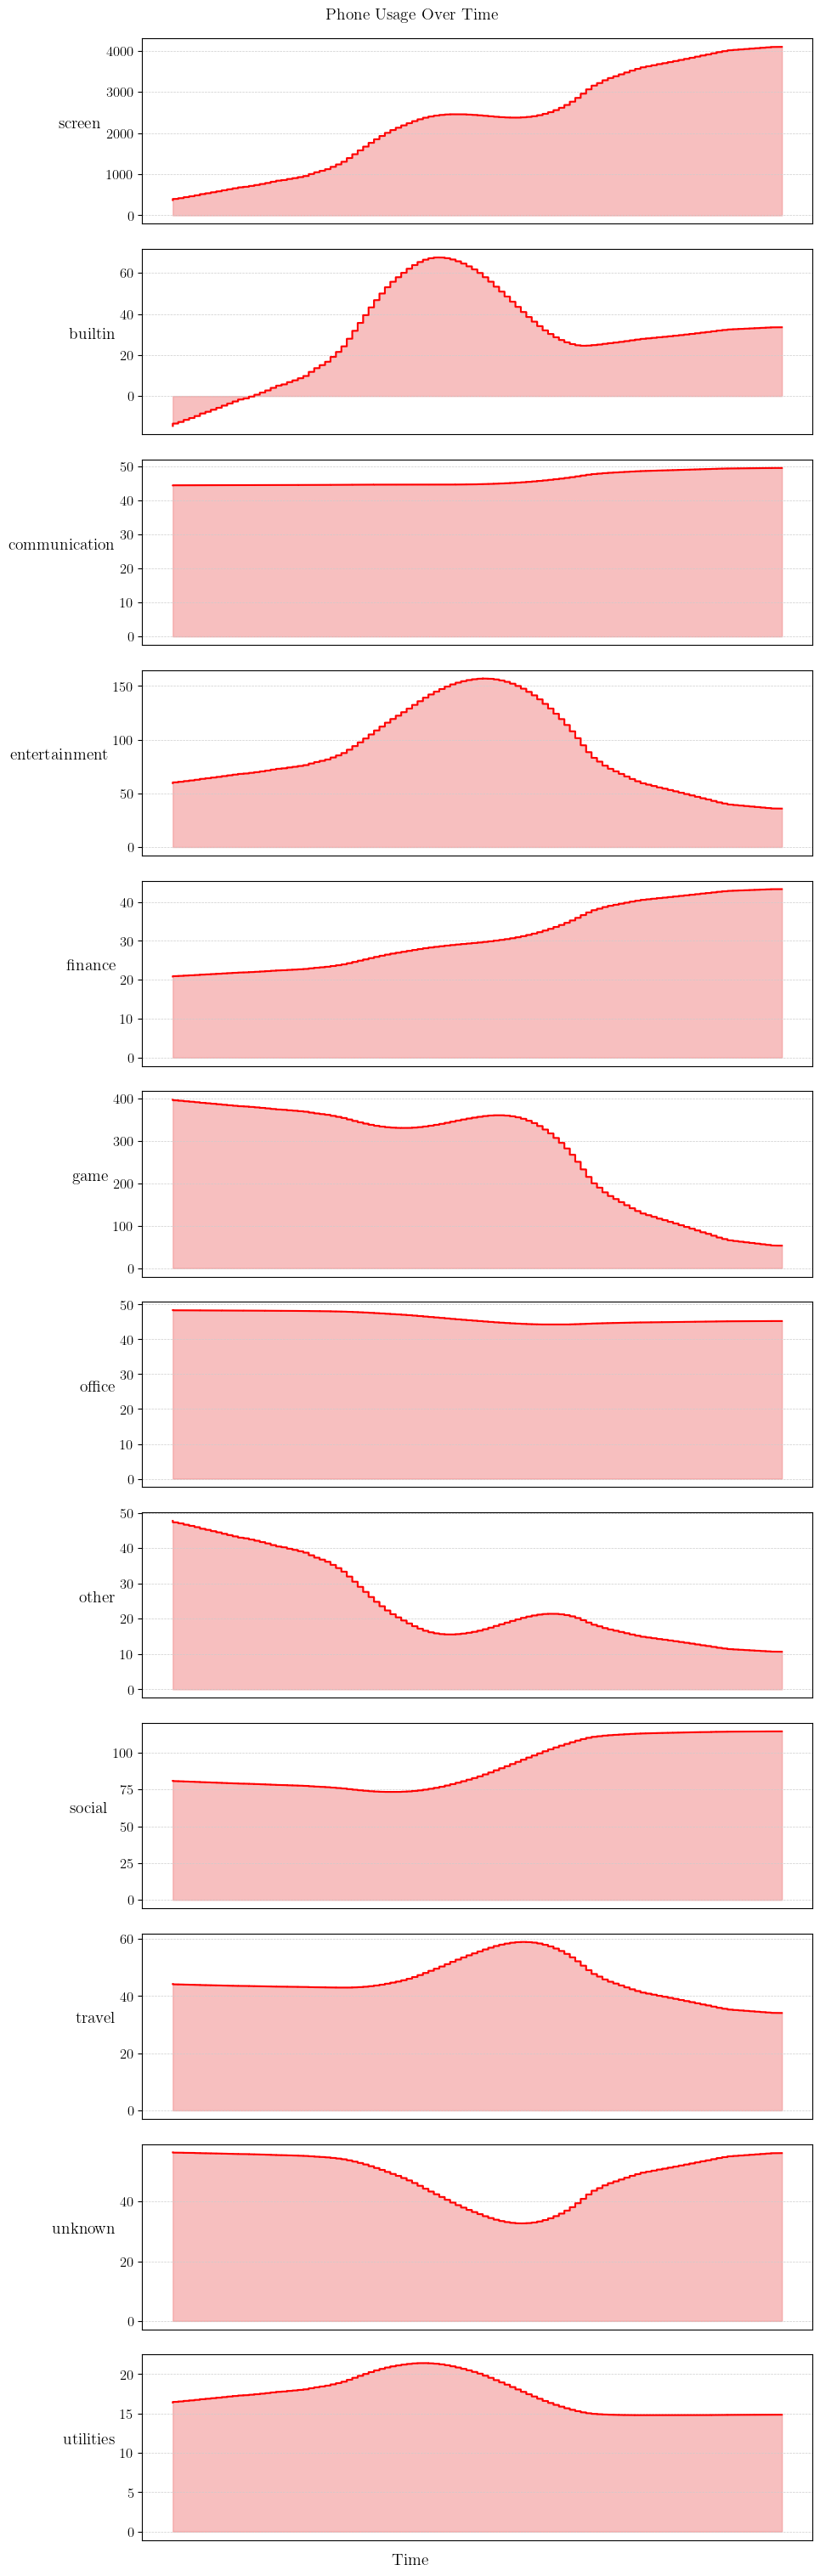

In [39]:
#Trying polynomial regression for trendlines because otherwise the data is kind of choppy

fig, axes = plt.subplots(nrows=12, ncols=1, figsize=(10, 30))

for i, data in enumerate([sorted_screen, sorted_builtin, sorted_communication, 
                          sorted_entertainment, sorted_finance, sorted_game, sorted_office, 
                          sorted_other, sorted_social, sorted_travel, sorted_unknown, sorted_utilities]):
    x = np.arange(len(sorted_time_marks))
    y = np.array(data)
    z = np.polyfit(x, y, 3)  
    p = np.poly1d(z)
    axes[i].plot(sorted_time_marks, p(x), label='Trendline', color='red')
    axes[i].fill_between(sorted_time_marks, p(x), color='lightcoral', alpha=0.5)

#Messing with labels and formatting
fig.text(0.4, 1, 'Phone Usage Over Time', va='center', rotation='horizontal', fontsize=14)
fig.text(0.5, 0, 'Time', ha='center', fontsize=14)
for ax in axes:
    ax.set_xticklabels([])
    ax.set_xticks([])
y_labels = ['screen','builtin','communication','entertainment','finance',
            'game','office','other','social','travel','unknown','utilities']
for i, ax in enumerate(axes):
    ax.set_ylabel(y_labels[i], rotation=0, ha='right')
    
plt.tight_layout()
plt.show()